# Hyperparameters and Model Validation

In the introduction to scikit-learn notebook, we briefly explored supervised and unsupervised learning. When building an ML model, a simple 4-step plan was shown. In this notebook, we're going to look closer at the first two steps: choosing a class of model, and the model hyperparameters.

### Naive model valuation

In [23]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data, iris.target

from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X,y)
y_model = model.predict(X)

from sklearn.metrics import accuracy_score as acc
acc(y, y_model)

1.0

An accuracy of 100%? Seems a little *too* perfect, no? Main thing being, our training and testing data are the exact same - so for this specific instance, it has 100% accuracy! This is bad practice, as ML models help us predict values for unidentified data.

So how do we counter this? We can create a *holdout set*: holding back some of the training data to test the model on.

In [24]:
from sklearn.model_selection import train_test_split
X1, X2, y1, y2 = train_test_split(X, y, random_state=0, train_size=0.5)

model.fit(X1, y1)
y2_model = model.predict(X2)
acc(y2, y2_model)

0.9066666666666666

91% accuracy seems a little more realistic. But now we have another issue - we're only testing and training on specific halves of the data. We can address this via *cross-validation,* using a sequence of fits where each subset of data is used both as training and validation sets.

In [25]:
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
acc(y1, y1_model), acc(y2, y2_model)

(0.96, 0.9066666666666666)

We can take this a step even further, and use either `cross_val_score()` or the `LeaveOneOut()` method. 

In [26]:
from sklearn.model_selection import cross_val_score, LeaveOneOut
cross_val_score(model, X, y, cv=5)
cross_val_score(model, X, y, cv=LeaveOneOut())

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### The Bias-Variance trade-off

When finding the optimal model to implement, it's a tradeoff between the variance and bias. Consider the following:



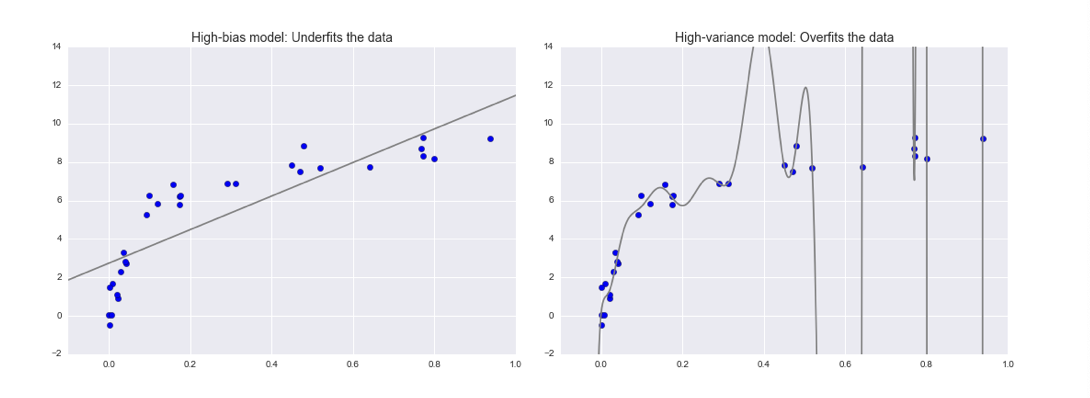


Generally speaking:
- High-bias model performance on the validation set is similar to the performance on the training set
- High-variance models performance is worse on the validation set than it is on the training set.

If we imagine that we have the ability to tune the models complexity, we would expect the training score and validation score to behave as illustrated in the following figure:

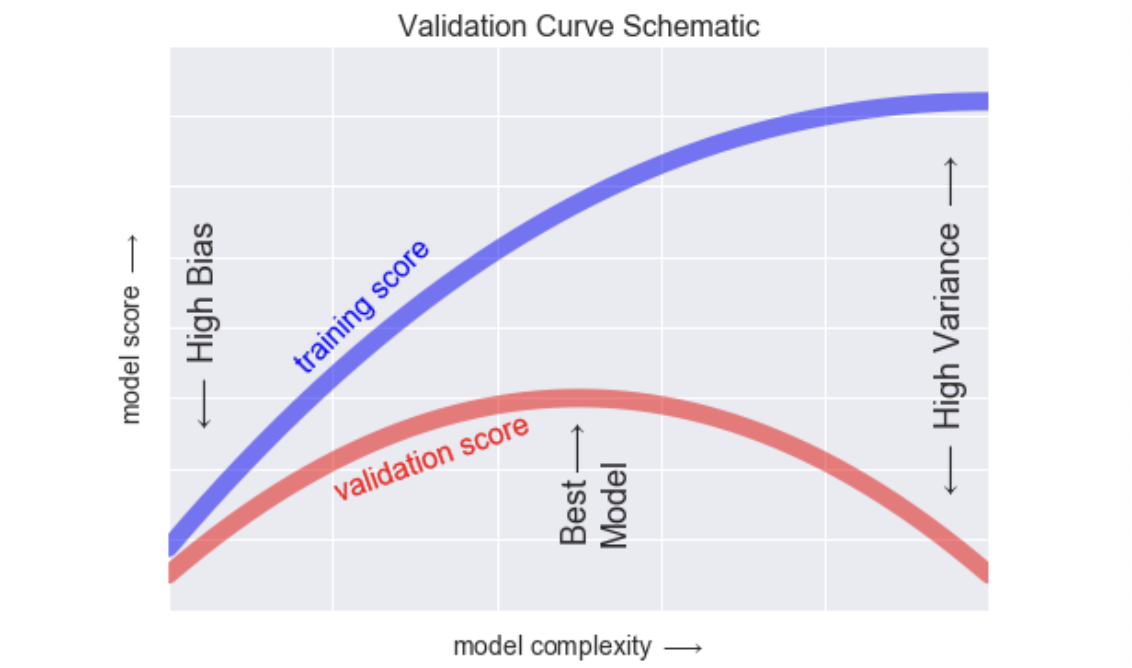

This diagram is commonly known as a *validation curve*:
- The training score is higher than the validation score for all points. This means the model will fit data it has seen as opposed to new data. As we'd expect.
- For a low model complexity, high-bias, the training data is underfit, meaning the model is a poor predictor for both training and unseen data.
- For a high-variance model, we can see the model is overfit: training score is high but will fail for new data. 
- A midpoint between the two is a tradeoff.

### Validation curves within Scikit-learn

Some examples of cross-validation for computing the validation curve for specific models:

First, we'll use a polynomial regression model: a generalised linear model in which the degree of the polynomial is a tunable parameter. A degree-1 polynomial follows a typical

$$ y = ax + b, $$ whereas a degree-3 polynomial is a typical cubic: $$ y = ax^3 + bx^2 + cx + d, $$

just as we'd expect.

In Scikit-Learn, we implement this linear regression with the polynomial preprocessor. A pipeline strings these operations together (which will be covered in more depth within the Feature Engineering notebook).

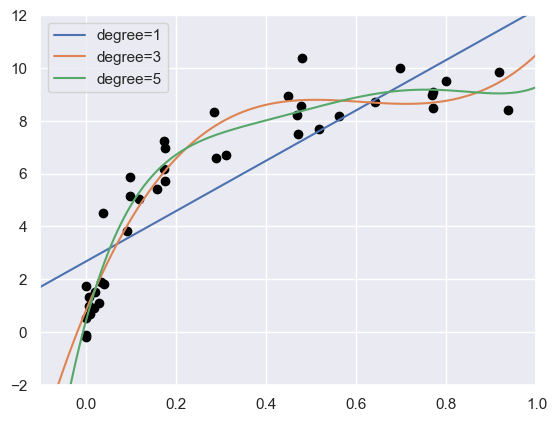

In [27]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolyReg(degree = 2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

# create some data

import numpy as np

def make_data(N, err=1.0, rseed=1):
    # random samples of data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + .1)
    if err > 0:
        y += err * rng.randn(N)

    return X, y

X, y = make_data(40)

# Visualise the data
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set()
X_test = np.linspace(-0.1, 1.1, 500)[:, None]
plt.scatter(X.ravel(), y, color="black")
axis = plt.axis()
for degree in [1,3,5]:
    y_test = PolyReg(degree).fit(X,y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label=f"degree={degree}")

plt.xlim(-0.1,1.0)
plt.ylim(-2,12)
plt.legend(loc="best")

Now we can visualise what degree polynomial has the best fit with the data generated. By inspection we can see it's degree=3.

We can go further twith this analysis by visualising the validation curve for this model and data. Conveniently, Scikit-Learn provides us a method for doing this. 

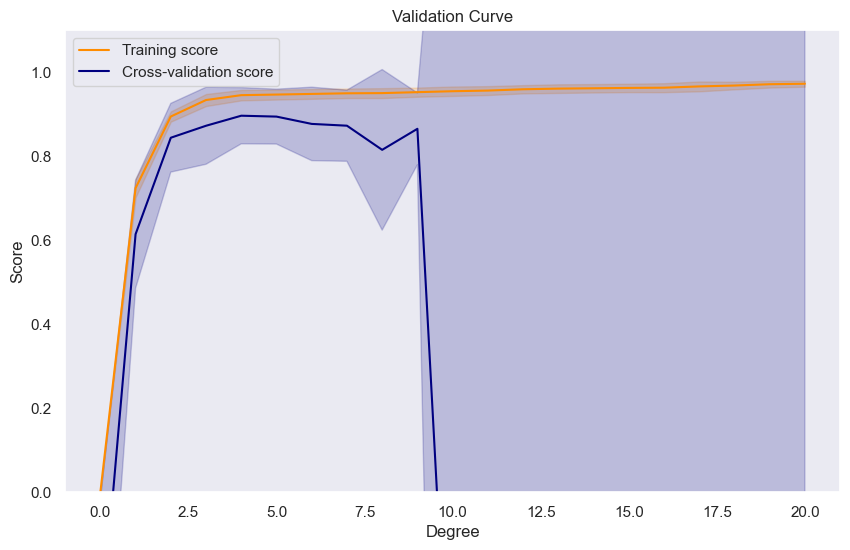

In [28]:
from sklearn.model_selection import validation_curve
degree = np.arange(0,21)

train_scores, valid_scores = validation_curve(
    PolyReg(), X, y, param_name='polynomialfeatures__degree', param_range=degree, cv=5
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.title("Validation Curve")
plt.xlabel("Degree")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.grid()

plt.plot(degree, train_scores_mean, label="Training score", color="darkorange")
plt.fill_between(
    degree,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange"
)
plt.plot(degree, valid_scores_mean, label="Cross-validation score", color="navy")
plt.fill_between(
    degree,
    valid_scores_mean - valid_scores_std,
    valid_scores_mean + valid_scores_std,
    alpha=0.2,
    color="navy"
)

plt.legend(loc="best")
plt.show()


### Learning Curves

The optimal model will generally depend on the size of your training data. The behaviour of the validation curve has two important inputs: the **model complexity** and the **number of training points.** 

We can explore the behavior of the model as a function of the number of training points, which we can do by using increasingly larger subsets of the data to fit our model. A plot of the training / validation score wrt. the size of the training set is known as the learning curve.

Typical behaviour for a learning curve is as follows:
- A model of some complexity will *overfit* a small dataset: high training score, low validation.
- A model of some complexity will *underfit* a large dataset: low training, high validation
- A model will **never, except by chance,** give a better validation score than training score. The curves should be converging, but never intersecting.

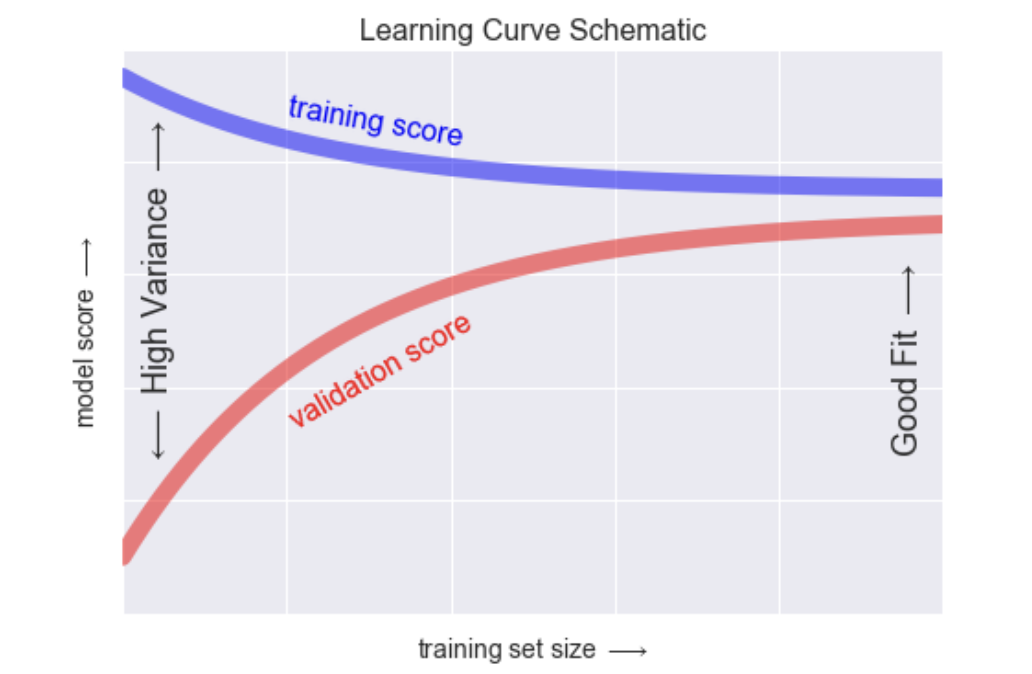

Let's implement one:


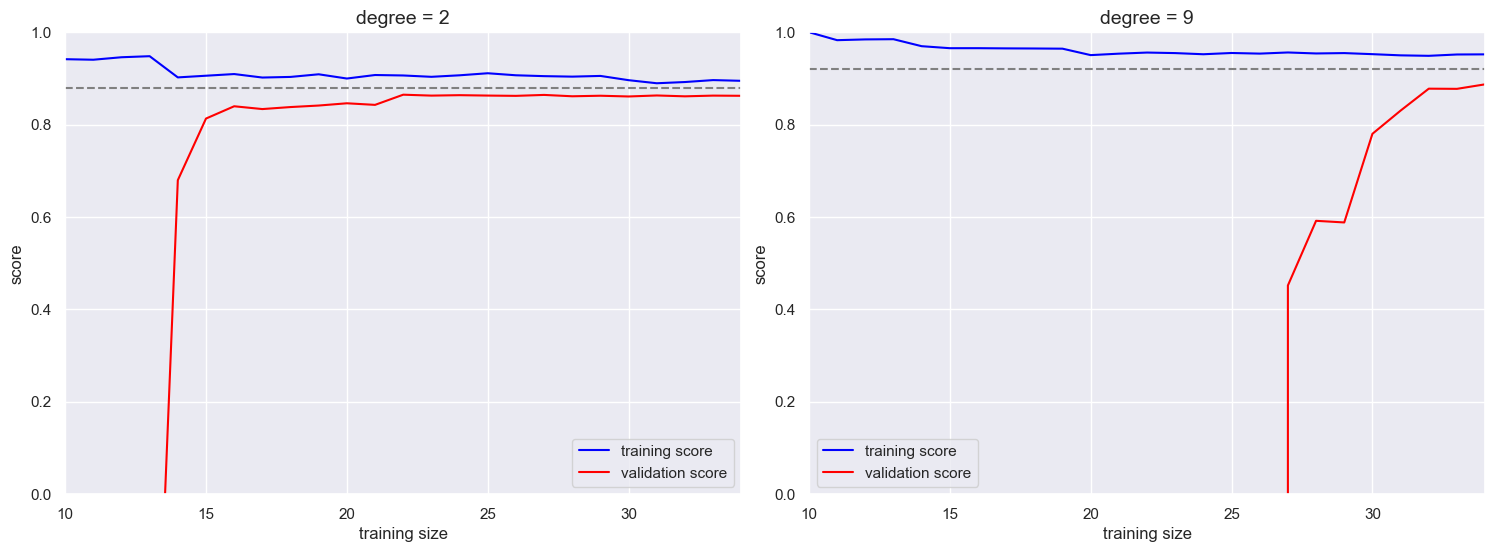

In [29]:
from sklearn.model_selection import learning_curve
fig, ax = plt.subplots(1,2,figsize=(16,6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(
        PolyReg(degree), X, y, train_sizes=np.linspace(0.3,1,25), cv=7
    )
    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')


The graphs above visualise how the model responds to increasing training data. When the learning curve has already converged, adding more training data will *not* improve the fit, as shown on the left. The only way to increase the converged score is using a different model, as shown in the right: by increasing the convergence score (dashed line), at the cost of higher variance.

### Applying it in practice

So what have I learned? Models have different knobs to turn, changing the plots of validation and learning curves. In higher dimensions, this can be tough to visualise, so it's easier to find a model that maximises the validation score. A real "here's one I made earlier moment," Scikit-Learn provides automated tools to do this. We'll use the grid search method to find the optimal polynomial model across a 3D grid of features.

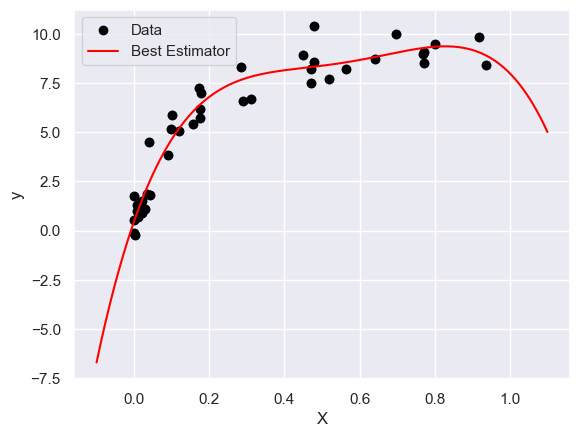

In [33]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "polynomialfeatures__degree" : np.arange(21)
}
# Instantiate estimator
grid = GridSearchCV(estimator=PolyReg(), param_grid=param_grid, cv=7, scoring="neg_mean_squared_error")
grid.fit(X,y)
# Find best parameters
grid.best_params_
# Use best params

model = grid.best_estimator_
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X,y).predict(X_test)
plt.scatter(X.ravel(), y, color="black", label="Data")
plt.plot(X_test.ravel(), y_test, color="red", label="Best Estimator")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()